This notebook tests the maximum WTA problem size that can be computed in five minutes on this machine. The problem size in three scenarios is increased until the computation time exceeds five minutes.

We then plot the results.

In [1]:
# %load wta.py
import cvxpy as cp
import numpy as np
from microbench import MicroBench
basic_bench = MicroBench()
from time import time 
np.random.seed(1)

@basic_bench
def solve_wta(q, V, W, integer=True, lasso=False, verbose=False):
    """
    Solve the weapon-target assignment problem.
    Inputs:
        q: (n,m) array of survival probabilities
        V: (n,) array of target values
        W: (m,) array of weapon counts
        integer: boolean, whether to solve the integer or continuous problem
        lasso: boolean, whether to solve the lasso problem
    """
    if len(q.shape) == 1:
        n = q.shape[0]
        m = 1
        q = q.reshape((n,m))
    else:
        n, m = q.shape

    # Define the CVXPY problem.
    if integer:
        x = cp.Variable((n,m), integer=True)
    else:
        x = cp.Variable((n,m))
    weighted_weapons = cp.multiply(x, np.log(q)) # (n,m)
    survival_probs = cp.exp(cp.sum(weighted_weapons, axis=1)) # (n,)
    
    if lasso:
        v = 0.1*min(V)
        obj_fun = V@survival_probs + v*cp.sum(x)
    else:
        obj_fun = V@survival_probs
    objective = cp.Minimize(obj_fun)
    cons = [cp.sum(x, axis=0) <= W, x >= 0]

    # Solve
    prob = cp.Problem(objective, cons)

    # Use mosek timelimit
    prob.solve(solver=cp.MOSEK, 
               mosek_params={'MSK_DPAR_OPTIMIZER_MAX_TIME': 300.0}, 
               verbose=verbose)
    if prob.status != 'optimal':
        print(prob.status) 

    return prob.value, x.value

def get_final_surv_prob(q, x):
    """
    Get the final probability of kill for each target.
    Inputs:
        q: (n,m) array of survival probabilities
        x: (n,m) array of weapon assignments
    """
    return np.prod(np.power(q, x), axis=1)

def get_ind_value(q, V, W):
    """
    Get the total value if each platform solves independently.
    Inputs:
        q: (n,m) array of survival probabilities
        V: (n,) array of target values
        W: (m,) array of weapon counts
    """
    # Loop through platforms
    n, m = q.shape
    x = np.zeros((n,m))
    for i in range(m):
        # Solve the WTA problem for platform i
        q_i = q[:,i]
        pv, x_i = wta(q_i, V, W[i])
        x[:,i] = x_i[:,0]
    return V@get_final_surv_prob(q, x), x

def generate_random_problem(n=5, m=3):
    """
    Generate a random problem.
    Inputs:
        n: number of targets
        m: number of weapon types
    """
    #np.random.seed(1)
    q = np.random.rand(n,m)*.8 + .1 # Survival probability
    V = np.random.rand(n)*100 # Value of each target
    W = np.random.randint(1,10,m) # Number of weapons of each type
    return q, V, W

(CVXPY) Jan 16 09:26:52 AM: Encountered unexpected exception importing solver SCS:
ImportError('libmkl_rt.so.2: cannot open shared object file: No such file or directory')


In [5]:
n = 10000
m = 1000
q, V, W = generate_random_problem(n,m)
solve_wta(q, V, W, integer=False, lasso=False, verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jan 16 09:36:59 AM: Your problem has 10000000 variables, 2 constraints, and 0 parameters.
(CVXPY) Jan 16 09:36:59 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 16 09:36:59 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 16 09:36:59 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 16 09:36:59 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jan 16 09:36:59 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuf

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

In [7]:
sum(W)

5007

In [6]:
# n varies, m varies
results = []
max_t = 0
n = 45
m = 45
cutoff = 5*60
while max_t < cutoff:
    # Generate random problem
    for i in range(35):
        q, V, W = generate_random_problem(n, m)
        # tic
        t = time()
        #@basic_bench
        solve_wta(q, V, W, integer=False)
        # toc
        t = time() - t
        max_t = max(max_t, t)
        print(n, m, t)
        results.append((n, m, i, t))
        
    if n == m:
        n += 4
    else:
        m += 4


45 45 0.03532838821411133
45 45 0.03127741813659668
45 45 0.031239032745361328
45 45 0.04214000701904297
45 45 0.03222393989562988
45 45 0.0361177921295166
45 45 0.03306698799133301
45 45 0.03152060508728027
45 45 0.031549930572509766
45 45 0.030187606811523438
45 45 0.03470492362976074
45 45 0.03079509735107422
45 45 0.03158736228942871
45 45 0.03246903419494629
45 45 0.03338789939880371
45 45 0.03525519371032715
45 45 0.03221845626831055
45 45 0.032437801361083984
45 45 0.031542301177978516
45 45 0.03096318244934082
45 45 0.030869245529174805
45 45 0.03153061866760254
45 45 0.03260326385498047
45 45 0.03253769874572754
45 45 0.030613422393798828
45 45 0.03409743309020996
45 45 0.03235507011413574
45 45 0.03250002861022949
45 45 0.033591270446777344
45 45 0.03206515312194824
45 45 0.034746646881103516
45 45 0.03245830535888672
45 45 0.030274152755737305
45 45 0.03259706497192383
45 45 0.030966520309448242
49 45 0.03938555717468262
49 45 0.03491330146789551
49 45 0.035625457763671875
4

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

In [3]:
bad_q = q.copy()
bad_V = V.copy()
bad_W = W.copy()


[[0.48682487 0.44248451 0.4019743  0.73973321 0.67261208 0.89010314
  0.69992782 0.18597168 0.24186869 0.30682113 0.16708753 0.89298861
  0.75368622 0.7508218  0.68140315 0.37058867 0.16336115 0.57090752
  0.44154147 0.22034127 0.26571026 0.68172888 0.30875071]
 [0.86008002 0.31543504 0.10487327 0.60240742 0.1574352  0.52282935
  0.40379848 0.61419496 0.89361077 0.30627724 0.29393942 0.24278949
  0.70031801 0.74730109 0.73618092 0.88533647 0.14942382 0.20241708
  0.32627441 0.49155093 0.59756859 0.69663346 0.65113649]
 [0.46205858 0.30538623 0.57330107 0.60661435 0.85743844 0.58663816
  0.36178275 0.88057986 0.24001494 0.6517416  0.22487477 0.66005039
  0.88680337 0.74629049 0.69957997 0.35560124 0.15586395 0.21915463
  0.70250687 0.45696293 0.34495466 0.24369079 0.53677797]
 [0.29257531 0.22277746 0.86291484 0.87334014 0.72869908 0.76089659
  0.12596208 0.67286951 0.3961991  0.15597265 0.15993814 0.25548759
  0.32679031 0.63300512 0.88750789 0.30811682 0.86695314 0.18309982
  0.682569

In [4]:

# print(bad_q, bad_V, bad_W)
solve_wta(bad_q, bad_V, bad_W, integer=False, verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jan 16 09:21:14 AM: Your problem has 552 variables, 2 constraints, and 0 parameters.
(CVXPY) Jan 16 09:21:14 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 16 09:21:14 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 16 09:21:14 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 16 09:21:14 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jan 16 09:21:14 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

[(10, 14, 0, 0.43731212615966797), (10, 14, 1, 1.0430047512054443), (10, 14, 2, 1.473449468612671), (10, 14, 3, 3.3537824153900146), (10, 14, 4, 4.8182291984558105), (10, 14, 5, 0.856499433517456), (10, 14, 6, 1.0522425174713135), (10, 14, 7, 2.373690366744995), (10, 14, 8, 2.560347080230713), (10, 14, 9, 1.0198979377746582), (10, 14, 10, 0.41313672065734863), (10, 14, 11, 1.0681860446929932), (10, 14, 12, 20.42479681968689), (10, 14, 13, 2.868011713027954), (10, 14, 14, 0.9098420143127441), (10, 14, 15, 1.8046979904174805), (10, 14, 16, 0.8378231525421143), (10, 14, 17, 35.77011799812317), (10, 14, 18, 1.0108356475830078), (10, 14, 19, 0.7827658653259277), (10, 14, 20, 1.4084174633026123), (10, 14, 21, 8.621549129486084), (10, 14, 22, 2.2555041313171387), (10, 14, 23, 0.6762754917144775), (10, 14, 24, 1.5845327377319336), (10, 15, 0, 1.0203862190246582), (10, 15, 1, 3.581156015396118), (10, 15, 2, 1.305128574371338), (10, 15, 3, 0.9808926582336426), (10, 15, 4, 2.948983907699585), (10

      n   m   i           t  prob_size
0    10  14   0    0.437312        140
1    10  14   1    1.043005        140
2    10  14   2    1.473449        140
3    10  14   3    3.353782        140
4    10  14   4    4.818229        140
..   ..  ..  ..         ...        ...
414  14  13  20   35.992648        182
415  14  13  21  300.059422        182
416  14  13  22    1.729897        182
417  14  13  23    1.972501        182
418  14  13  24    5.499739        182

[419 rows x 5 columns]


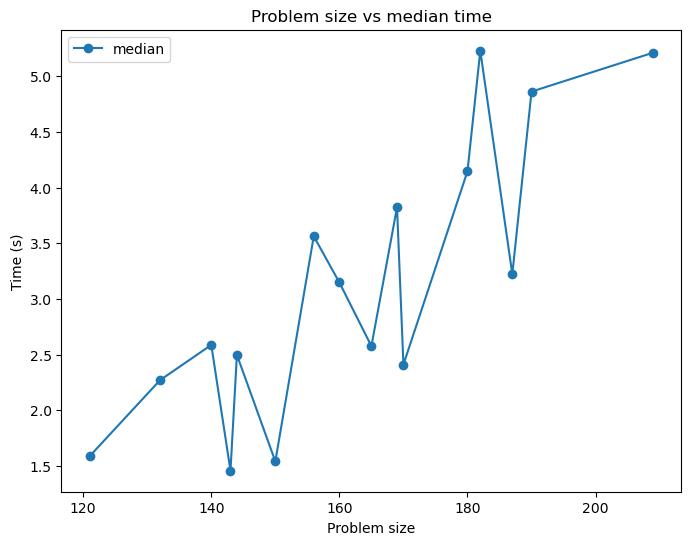

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [32]:
# Plot

df = pd.DataFrame(results, columns=['n', 'm', 'i', 't'])
df['t'] = df['t'].astype(float)

df['prob_size'] = df['n']*df['m']
df['prob_size'] = df['prob_size'].astype(int)

# Plot just problem size vs median time excluding groups with less than five data points
# Form subset of data with at least five data points
df_subset = df.groupby('prob_size').filter(lambda x: len(x) >= 5)
print(df_subset)

plt.figure(figsize=(8,6))
#plt.plot(df_subset.groupby('prob_size')['t'].max(), 'o-')
#plt.plot(df_subset.groupby('prob_size')['t'].quantile(.75), 'o-')
plt.plot(df_subset.groupby('prob_size')['t'].median(), 'o-')
#plt.plot(df_subset.groupby('prob_size')['t'].quantile(.25), 'o-')
#plt.plot(df_subset.groupby('prob_size')['t'].median(), 'o-')
plt.xlabel('Problem size')
plt.ylabel('Time (s)')
plt.legend(['median']) #'max', '75th percentile', , '25th percentile'
plt.title('Problem size vs median time')
plt.show()

# Save figure
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
plt.savefig('m_time_'+timestamp+'.png')

Text(0.5, 1.0, 'Count of each problem size')

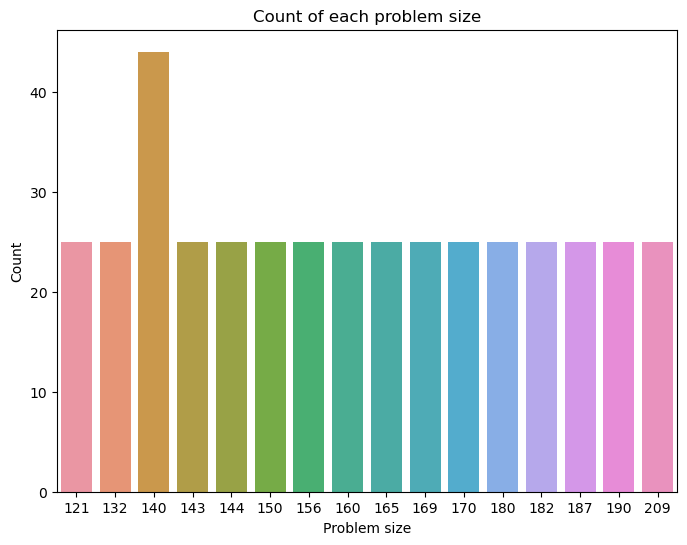

In [30]:
# Show count of each problem size
plt.figure(figsize=(8,6))
sns.countplot(x='prob_size', data=df_subset)
plt.xlabel('Problem size')
plt.ylabel('Count')
plt.title('Count of each problem size')

In [31]:
# Export data to csv with timestamp
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M")

df.to_csv('m_time_'+timestamp+'.csv')